# Road Network Simplification of Roundabouts
The following code exemplifies a simple process for road network simplification of roundabouts using [momepy.roundabour_simplification()](http://docs.momepy.org/en/latest/generated/momepy.roundabout_simplification.html?highlight=momepy.roundabout_simplification).

For this example we will fetch some data from [Open Street Map](https://www.openstreetmap.org/#map=6/40.007/-2.488) (using [osmnx](https://osmnx.readthedocs.io/en/stable/)). However, most other data sources should also work as long as their topology has been corrected and can be sotred in a GeoDataFrame.
The underneath code uses only geometry operation to perform the simplification.

**Part of GSOC2022** 

The function was originally developed by [Greg Maya](https://github.com/gregmaya) and supervised by [Martin Fleischmann](https://github.com/martinfleis), [James Gaboardi](https://github.com/jGaboardi) and [Andres Morfin](https://github.com/amorfinv)

It depends on the following packages:

```
- momepy
- geopandas
- osmnx
```

In [1]:
import geopandas as gpd
import momepy as mm 
import osmnx as ox

import matplotlib.pyplot as plt

## Load data
Using **OSMNX** download a neighborhood and its corresponding **crs**

Note that two things help imporve the reults:
1. reproject the the network to a projected CRS (in meters)
1. transform the graph to an undirected graph:
    -  This helps to remove overlaping LineString once moving to GDF 


In [2]:
place = "Chamberi, Madrid"
local_crs = 2062

G = ox.graph_from_place(place, network_type='drive', simplify = True, buffer_dist= 200 )
G_projected = ox.project_graph(G)

edges = ox.graph_to_gdfs(
    ox.get_undirected(G_projected), #prevents some (semi)duplicate geoms
    nodes=False,
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True)

edges.to_crs(local_crs, inplace= True)
edges.head(3)

osmid  oneway                      name  \
u        v          key                                                
21990706 21990729   0    390868364    True  Calle de Mejía Lequerica   
21990729 25906107   0    163743121    True  Calle de la Beneficencia   
         3144095503 0    390868364    True  Calle de Mejía Lequerica   

                             highway reversed  length  \
u        v          key                                 
21990706 21990729   0    residential    False  60.664   
21990729 25906107   0    residential    False  65.736   
         3144095503 0    residential    False   1.550   

                                                                  geometry  \
u        v          key                                                      
21990706 21990729   0    LINESTRING (599127.401 647281.632, 599084.812 ...   
21990729 25906107   0    LINESTRING (599084.812 647324.782, 599133.124 ...   
         3144095503 0    LINESTRING (599084.812 647324.782, 599083.490 ...   

                             from          to maxspeed lanes bridge access  \
u        v          key                                                      
21990706 21990729   0    21990706    21990729      NaN   NaN    NaN    NaN   
21990729 25906107   0    21990729    25906107      NaN   NaN    NaN    NaN   
         3144095503 0    21990729  3144095503      NaN   NaN    NaN    NaN   

                        tunnel junction  
u        v          key                  
21990706 21990729   0      NaN      NaN  
21990729 25906107   0      NaN      NaN  
         3144095503 0      NaN      NaN

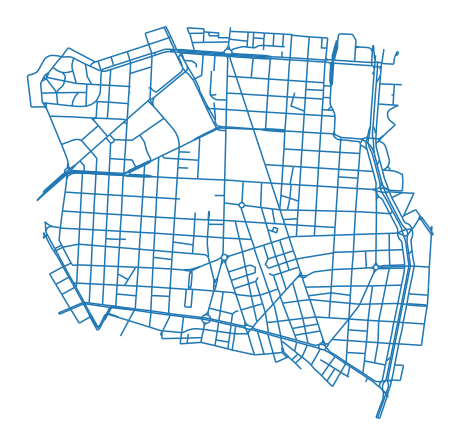

In [3]:
edges.plot(figsize = (8,12))
plt.axis("off");

## Playing with the different parameters
### _default_

In [4]:
edges_output = mm.roundabout_simplification(edges)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [5]:
m = edges.explore(tiles = "CartoDB Positron", color= 'black', legend= "Orignal Road Network" )
edges_output.explore(m=m, color = "red", legend = "Simplified network (default)" )
m

Using the output column _```simplification_group```_ we can count the number of roundabouts that were simplified

In [6]:
edges_output.simplification_group.nunique()

7

In total **7** roundabouts were simplified, and most of their incoming edges were also considered turing the process. 

However, it's worth investigating why some roundabouts are still missing.
So, the selection of rounabouts is based on the resulting polygons after polygonizing the road network.

Let's investigate the resulting polygons and add [Circular Compactness](https://docs.momepy.org/en/stable/generated/momepy.CircularCompactness.html) parameter which is the main selection method.

In [7]:
from shapely.ops import polygonize

polys = gpd.GeoDataFrame(geometry=[g for g in polygonize(edges.geometry)], crs=edges.crs)
circom_serie = mm.CircularCompactness(polys).series
polys.loc[:, "circom"] = circom_serie

The _```circom_threshold```_ parameter (default = 0.7) establishes the limit at which to select roundabouts

In [8]:
circom_threshold = 0.7
mask = circom_serie > circom_threshold
colors = ["green" if m == True else "#dbdada" for m  in mask]

polys.reset_index().explore(tiles= "CartoDB positron", color = colors)

One can notice two main reasons why some roundabouts are snot being selected:
1. they are crossed by other roads; which breaks them into multiple polygons
    - eg. `index`: ```[314, 312, 304]``` (towards the **WEST** boundary of the sample)
1. they don't meet the `circom_threshold`
     - eg. `index`: ```[162]``` --> (0.67) (towards the **SOUTH** boundary of the sample)

Finally, let's also explore what the outcome would look like if `include_adjacent` is set to `False`
## Lowering _**circom_threshold**_ & **include_adjacent**_ = False


In [9]:
edges_output_65 = mm.roundabout_simplification(edges, circom_threshold= 0.65, include_adjacent=False)

edges_output_65.explore(m=m, color = "blue")
m

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [10]:
edges_output_65.simplification_group.nunique()

13

Eventhough we have been able to simplify **13** supposedly polygons, this sample now contains some false positives. So it's up to each case to decide the right balance so as to make the most of this simplification. 

Note that this is a work in progress and some upcoming enhancements are expected to complement this approach.
